In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/My Drive/Colab Notebooks/upskilling/transformers_ch1

/content/drive/My Drive/Colab Notebooks/upskilling/transformers_ch1


# Chapter 1 - Transformers
## Deep Learning Curriculum - Jacob Hilton

### Theory

* Here are some first principle questions to answer:
1. What is different architecturally from the Transformer, vs a normal RNN, like an LSTM? (Specifically, how are recurrence and time managed?)

    In an RNN, input data is processed sequentially. Given an initial hidden-state and the first input token, the RNN rolls-out, where each subsequent copy of the neural network receives the hidden-state of the previous NN (supposedly containing the memory of the network and the context prior to the current position) and the current token being processed. Thus, the RNN deals with the sequential nature of the input data by literally processing the input sequentially. Other than the fact that RNNs keep a memory of the previous outputs used in present computations, in the form of hidden states, there architecture is very similar to an MLP, in that they have input, hidden and output layers. There is no need to positionally encode the tokens since they are being processed one at a time in the position in which they find themselves.

    In a Transformer network, input sequences are not processed sequentially. Given an input sequence of tokens, the attention mechanism operates over the whole sequence at once. Ouery, key and value representations of the encoded tokens are generated using the learned linear projection matrices. The attention pattern is calculated from the dot-product between queries and keys. After softmax is applied to the attention pattern column-wise, each element in each column is used as the scalers on a linear combination of the values in order to update current embeddings. After updating current embeddings, these are passed through an MLP. As the whole sequence is processed at once, in parallel, in order to capture the structure of the data, these must be positionally encoded.

2. Attention is defined as, $Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt(d_k)})V$. What are the dimensions for Q, K, and V? Why do we use this setup? What other combinations could we do with (Q,K) that also output weights?

    $dim(Q) = n_{tokens} \times d_k$

    $dim(K) = n_{tokens} \times d_k$

    $dim(V) = n_{tokens} \times d_v$

    Specifically in the paper $d_k = d_v = 64$. In terms of possible combinations of $Q$ and $K$, the only necessary condition is that there is one key and query vector for each token in the sequence and that these vectors are of the same size. Since at the end of a multi-head attention block the outputs from each head are concatenated, it is useful to have $d_k = d_{model}/h$ where $h$ is the number of heads. Thus, as stated in the paper, you can use values for $d_k$ such as 16, 32, 128, 64, 512 (for 32, 16, 4, 8 and 1 head, respectively). Also, due to this, you cannot use $d_k \gt d_{model}$, additionally beacuse it would make no sense to project the embeddings to a space higher than their own.

3. Are the dense layers different at each multi-head attention block? Why or why not?

    All the dense layers between the multi-head attention blocks are the same, in the sense that they have the same architecture, though their learned parameter values are of course different. They all act in the same vector spaces, and are used to capture more complex non-linear relationships in the data that the multi-head attention would have difficulty capturing. As they are applied position-wise, the input layer is of size $d_{model}/h$ and output layers must be of $d_{model}$ size. For simplicities sake the hidden-layer size is kept the same.

4. Why do we have so many skip connections, especially connecting the input of an attention function to the output? Intuitively, what if we didn't?

    We have these skip connections firstly because they represent the updating of the initial embeddings by the the linearly combined value vectors and secondly in order to reduce the problem of vanishing gradients. It is to eliminate loss of information in the residual stream.

### Code

* Now we'll actually implement the code. Make sure each of these is completely correct - it's very easy to get the small details wrong.
  * Implement the positional embedding function first.
  * Then implement the function which calculates attention, given (Q,K,V) as arguments.
  * Now implement the masking function.
  * Put it all together to form an entire attention block.
  * Finish the whole architecture.
* If you get stuck, The Annotated Transformer may help, but don't just copy-paste the code.
* To check you have the attention mask set up correctly, train your model on a toy task, such as reversing a random sequence of tokens. The model should be able to predict the second half of the sequence, but not the first.
* Finally, train your model on the complete works of William Shakespeare.
  * Tokenize the corpus by splitting at word boundaries (re.split(r"\b", ...)).
  * Make sure you don't use overlapping sequences as this can lead to overfitting.

## Packages

In [3]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import accuracy_score

# code
from scripts.models import *
from scripts.config import Configs

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Testing Functions

### Positional Encoding

In [5]:
cfg = Configs()

In [6]:
pe = PositionalEncoding(cfg)

In [7]:
pos_enc = pe.getPositionalEncoding()

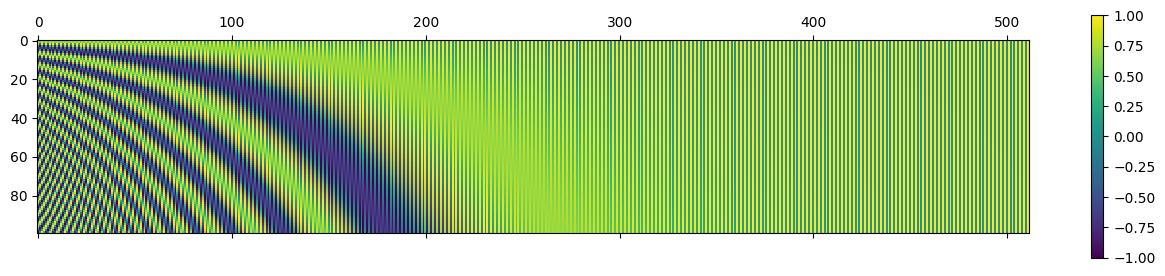

In [8]:
cax = plt.matshow(pos_enc.cpu())
plt.gcf().colorbar(cax)

### Attention

In [9]:
q = torch.randn((6, 64)).to(device)
k = torch.randn((6, 64)).to(device)
v = torch.randn((6, 64)).to(device)

att, att_pat = attention(q, k, v, 64)

In [10]:
att_pat.view(6, 6)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4325, 0.5675, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1409, 0.7387, 0.1205, 0.0000, 0.0000, 0.0000],
        [0.0462, 0.0258, 0.3322, 0.5958, 0.0000, 0.0000],
        [0.3075, 0.2435, 0.0537, 0.1188, 0.2766, 0.0000],
        [0.4653, 0.0732, 0.3557, 0.0616, 0.0140, 0.0301]], device='cuda:0')

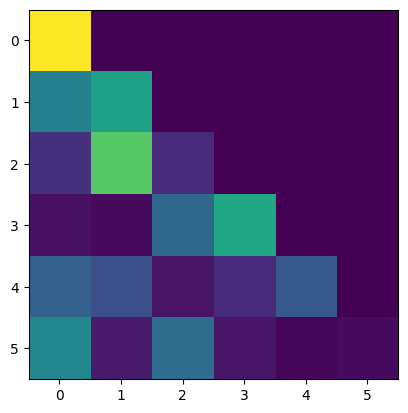

In [11]:
plt.imshow(att_pat.view(6, 6).cpu().detach().numpy())

## Reverse Sequence

The task here is to demonstrate how the masking performed in the attention step allows the transformer to predict the next tokens in a sequence, but prevents it from predicting previous ones.

### Generate Data

In [12]:
class SequenceReversalData(Dataset):
  def __init__(self, vocab_size=15, seq_len=6, d_size=1024):

    self.vocab_size=vocab_size
    self.seq_len=seq_len
    self.d_size=d_size

    # generate sequences
    self.data = np.random.randint(0, self.vocab_size, (self.d_size, self.seq_len))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):

    sequence = self.data[idx]
    reversed = sequence[::-1].copy()

    return sequence, reversed

In [13]:
val_size = 320
test_size = 320
batch_size = 32

In [14]:
train_data = SequenceReversalData()
valid_data = SequenceReversalData(d_size=val_size)
test_data = SequenceReversalData(d_size=test_size)

In [15]:
train_dlr = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dlr = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_dlr = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [16]:
cfg_revseq = Configs(
    N_HEADS = 4,
    D_MODEL = 128,
    SEQ_LEN = 6,
    BATCH_SIZE = 32,
    D_HIDDEN = 1024,
    DROPOUT = 0,
    N_LAYERS = 6
)

In [17]:
test_model = Transformer(vocab_size=15, config=cfg_revseq)
test_model = test_model.to(device)

In [18]:
ex1, labels = next(iter(train_dlr))

In [19]:
ex1 = ex1.to(device)

In [20]:
out = test_model(ex1)

### Training Function

In [21]:
def right_answers(output, rev):

  pred = output.argmax(dim=-1)
  right_answers = (pred == rev).sum().cpu().item()

  return right_answers

In [22]:
def train(m, dlrt, loss, optm, batch=32, seq_len=6):

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  m.to(device)
  m.train()
  train_running_loss = 0
  train_bar = tqdm(enumerate(dlrt), total=len(dlrt))
  right_ans = 0

  for i, (seq, rev) in train_bar:

    seq = seq.to(device)
    rev = rev.to(device)

    # zero the gradient
    optm.zero_grad()

    # forward
    output = m(seq)
    # get loss
    l = loss(output.view(-1, output.shape[-1]), rev.view(-1))

    # backpropagate
    l.backward()

    # gradient clipping
    clip_grad_norm_(m.parameters(), 1)

    # step
    optm.step()

    # update running loss
    train_running_loss += l.cpu().item()

    # calculating average accuracy
    right_ans += right_answers(output.cpu(), rev.cpu())

  print('Finished Batch: ')

  total_av_acc = right_ans / (len(dlrt) * batch * seq_len)
  epoch_loss = train_running_loss / len(dlrt)

  print('Training Loss: ', epoch_loss,
        'Training Accuracy Score: ', total_av_acc)

  return epoch_loss, total_av_acc

### Evaluation Function

In [23]:
def evaluate(m, dlrt, loss, batch=32, seq_len=6):


    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    m.eval()
    val_running_loss = 0
    test_bar = tqdm(enumerate(dlrt), total=len(dlrt))
    right_ans = 0

    for i, (seq, rev) in test_bar:

      seq = seq.to(device)
      rev = rev.to(device)

      # forward
      output = m(seq)

      # get loss
      l = loss(output.view(-1, output.shape[-1]), rev.view(-1))

      # update running loss
      val_running_loss += l.item()

      # calculating average accuracy
      right_ans += right_answers(output.cpu(), rev.cpu())

    total_av_acc = right_ans / (len(dlrt) * batch * seq_len)
    valid_loss = val_running_loss / len(dlrt)
    print('Validation Loss: ', valid_loss,
          'Validation Accuracy Score: ', total_av_acc)

    return valid_loss, total_av_acc

In [24]:
def earlystopping(valid_loss, min_valid_loss, start_patience, valid_acc):

  stop = False
  running_patience = start_patience
  if valid_acc == 1:
    stop = True

  if valid_loss < min_valid_loss:
    min_valid_loss = valid_loss
    running_patience = start_patience
  else:
    running_patience -= 1

  if running_patience == 0:
    stop = True

  return stop, running_patience, min_valid_loss

## Run Training - No Mask

In [ ]:
cfg_revseq = Configs(
    N_HEADS = 4,
    D_MODEL = 128,
    SEQ_LEN = 6,
    BATCH_SIZE = 32,
    D_HIDDEN = 1024,
    DROPOUT = 0,
    N_LAYERS = 6
)

In [ ]:
model = Transformer(vocab_size=15, mask=False, config=cfg_revseq).to(device)
loss = nn.CrossEntropyLoss()
max_epochs = 100
lr = 1e-2
optm = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
min_valid_loss = 1e9
patience = 5

In [ ]:
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
print('########### START ###########')
for e in range(max_epochs):
  print(e)
  train_loss, train_acc = train(model, train_dlr, loss, optm)
  valid_loss, valid_acc = evaluate(model, valid_dlr, loss)
  stop, patience, min_valid_loss = earlystopping(valid_loss, min_valid_loss, patience, valid_acc)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  train_accs.append(train_acc)
  valid_accs.append(valid_acc)
  if stop:
    break
    print('############ END ############')

########### START ###########
0


100%|██████████| 32/32 [00:03<00:00, 10.24it/s]


Finished Batch: 
Training Loss:  2.558150827884674 Training Accuracy Score:  0.15836588541666666


100%|██████████| 10/10 [00:00<00:00, 22.62it/s]


Validation Loss:  2.2201529026031492 Validation Accuracy Score:  0.275
1


100%|██████████| 32/32 [00:03<00:00,  9.45it/s]


Finished Batch: 
Training Loss:  1.9645090401172638 Training Accuracy Score:  0.31884765625


100%|██████████| 10/10 [00:00<00:00, 34.56it/s]


Validation Loss:  1.8299892783164977 Validation Accuracy Score:  0.3223958333333333
2


100%|██████████| 32/32 [00:02<00:00, 12.48it/s]


Finished Batch: 
Training Loss:  1.7421499378979206 Training Accuracy Score:  0.3310546875


100%|██████████| 10/10 [00:00<00:00, 33.23it/s]


Validation Loss:  1.7511436939239502 Validation Accuracy Score:  0.32864583333333336
3


100%|██████████| 32/32 [00:02<00:00, 12.09it/s]


Finished Batch: 
Training Loss:  1.6695482470095158 Training Accuracy Score:  0.3453776041666667


100%|██████████| 10/10 [00:00<00:00, 32.85it/s]


Validation Loss:  1.7139899611473084 Validation Accuracy Score:  0.3255208333333333
4


100%|██████████| 32/32 [00:02<00:00, 12.17it/s]


Finished Batch: 
Training Loss:  1.6239084303379059 Training Accuracy Score:  0.359375


100%|██████████| 10/10 [00:00<00:00, 26.34it/s]


Validation Loss:  1.6801769018173218 Validation Accuracy Score:  0.33645833333333336
5


100%|██████████| 32/32 [00:03<00:00,  8.12it/s]


Finished Batch: 
Training Loss:  1.576712228357792 Training Accuracy Score:  0.3761393229166667


100%|██████████| 10/10 [00:00<00:00, 24.43it/s]


Validation Loss:  1.6523963809013367 Validation Accuracy Score:  0.35208333333333336
6


100%|██████████| 32/32 [00:02<00:00, 12.45it/s]


Finished Batch: 
Training Loss:  1.5104652494192123 Training Accuracy Score:  0.40576171875


100%|██████████| 10/10 [00:00<00:00, 32.65it/s]


Validation Loss:  1.5708315014839171 Validation Accuracy Score:  0.3729166666666667
7


100%|██████████| 32/32 [00:02<00:00, 12.49it/s]


Finished Batch: 
Training Loss:  1.3824876807630062 Training Accuracy Score:  0.4529622395833333


100%|██████████| 10/10 [00:00<00:00, 34.26it/s]


Validation Loss:  1.4048110723495484 Validation Accuracy Score:  0.43385416666666665
8


100%|██████████| 32/32 [00:02<00:00, 12.17it/s]


Finished Batch: 
Training Loss:  1.1826921310275793 Training Accuracy Score:  0.5166015625


100%|██████████| 10/10 [00:00<00:00, 34.20it/s]


Validation Loss:  1.180371594429016 Validation Accuracy Score:  0.49270833333333336
9


100%|██████████| 32/32 [00:03<00:00,  9.52it/s]


Finished Batch: 
Training Loss:  0.9350483287125826 Training Accuracy Score:  0.62158203125


100%|██████████| 10/10 [00:00<00:00, 22.96it/s]


Validation Loss:  0.8352705359458923 Validation Accuracy Score:  0.6661458333333333
10


100%|██████████| 32/32 [00:03<00:00, 10.18it/s]


Finished Batch: 
Training Loss:  0.44592190627008677 Training Accuracy Score:  0.8857421875


100%|██████████| 10/10 [00:00<00:00, 33.59it/s]


Validation Loss:  0.1750711426138878 Validation Accuracy Score:  0.9864583333333333
11


100%|██████████| 32/32 [00:02<00:00, 12.24it/s]


Finished Batch: 
Training Loss:  0.054958635300863534 Training Accuracy Score:  0.9988606770833334


100%|██████████| 10/10 [00:00<00:00, 31.01it/s]


Validation Loss:  0.018017251510173082 Validation Accuracy Score:  0.9989583333333333
12


100%|██████████| 32/32 [00:02<00:00, 12.40it/s]


Finished Batch: 
Training Loss:  0.01001320788054727 Training Accuracy Score:  1.0


100%|██████████| 10/10 [00:00<00:00, 32.87it/s]

Validation Loss:  0.008621864672750234 Validation Accuracy Score:  1.0


In [ ]:
text_loss, test_acc = evaluate(model, test_dlr, loss)

100%|██████████| 10/10 [00:00<00:00, 33.56it/s]

Validation Loss:  0.008711210917681456 Validation Accuracy Score:  1.0


In [ ]:
ex1, label = next(iter(test_dlr))
ex1 = ex1.to(device)
label = label.to(device)

In [ ]:
res = model(ex1)

In [ ]:
res.argmax(dim=-1)[:5]

tensor([[ 7,  0,  7,  9,  1,  2],
        [ 7, 13, 12,  1,  4,  5],
        [ 2, 13,  7,  7,  3,  4],
        [ 0,  3,  2, 14,  9,  9],
        [ 1, 12,  8,  5,  6,  3]])

In [ ]:
label[:5]

tensor([[ 7,  0,  7,  9,  1,  2],
        [ 7, 13, 12,  1,  4,  5],
        [ 2, 13,  7,  7,  3,  4],
        [ 0,  3,  2, 14,  9,  9],
        [ 1, 12,  8,  5,  6,  3]])

### With Mask

In [ ]:
model_masked = Transformer(vocab_size=15, mask=True, config=cfg_revseq).to(device)
loss = nn.CrossEntropyLoss()
max_epochs = 100
lr = 2e-4
optm = torch.optim.Adam(model_masked.parameters(), lr=lr)
min_valid_loss = 1e9
patience = 10

In [ ]:
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
print('########### START ###########')
for e in range(max_epochs):
  print(e)
  train_loss, train_acc = train(model_masked, train_dlr, loss, optm)
  valid_loss, valid_acc = evaluate(model_masked, valid_dlr, loss)
  stop, patience, min_valid_loss = earlystopping(valid_loss, min_valid_loss, patience, valid_acc)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  train_accs.append(train_acc)
  valid_accs.append(valid_acc)
  if stop:
    break
    print('############ END ############')

########### START ###########
0


100%|██████████| 32/32 [00:03<00:00, 10.45it/s]


Finished Batch: 
Training Loss:  2.6617040261626244 Training Accuracy Score:  0.14290364583333334


100%|██████████| 10/10 [00:00<00:00, 33.48it/s]


Validation Loss:  2.5219555616378786 Validation Accuracy Score:  0.2140625
1


100%|██████████| 32/32 [00:03<00:00, 10.63it/s]


Finished Batch: 
Training Loss:  2.373971663415432 Training Accuracy Score:  0.22395833333333334


100%|██████████| 10/10 [00:00<00:00, 21.80it/s]


Validation Loss:  2.2254438161849976 Validation Accuracy Score:  0.23958333333333334
2


100%|██████████| 32/32 [00:04<00:00,  7.64it/s]


Finished Batch: 
Training Loss:  2.066930338740349 Training Accuracy Score:  0.2548828125


100%|██████████| 10/10 [00:00<00:00, 34.55it/s]


Validation Loss:  1.969505488872528 Validation Accuracy Score:  0.28177083333333336
3


100%|██████████| 32/32 [00:02<00:00, 11.15it/s]


Finished Batch: 
Training Loss:  1.8307695128023624 Training Accuracy Score:  0.34619140625


100%|██████████| 10/10 [00:00<00:00, 34.22it/s]


Validation Loss:  1.7067944884300232 Validation Accuracy Score:  0.42864583333333334
4


100%|██████████| 32/32 [00:02<00:00, 11.16it/s]


Finished Batch: 
Training Loss:  1.5114862211048603 Training Accuracy Score:  0.5107421875


100%|██████████| 10/10 [00:00<00:00, 34.55it/s]


Validation Loss:  1.4000589013099671 Validation Accuracy Score:  0.5395833333333333
5


100%|██████████| 32/32 [00:02<00:00, 11.37it/s]


Finished Batch: 
Training Loss:  1.3798862732946873 Training Accuracy Score:  0.5377604166666666


100%|██████████| 10/10 [00:00<00:00, 23.24it/s]


Validation Loss:  1.383493149280548 Validation Accuracy Score:  0.5348958333333333
6


100%|██████████| 32/32 [00:04<00:00,  7.71it/s]


Finished Batch: 
Training Loss:  1.3668300472199917 Training Accuracy Score:  0.5392252604166666


100%|██████████| 10/10 [00:00<00:00, 33.19it/s]


Validation Loss:  1.3804993271827697 Validation Accuracy Score:  0.534375
7


100%|██████████| 32/32 [00:02<00:00, 11.14it/s]


Finished Batch: 
Training Loss:  1.3618548773229122 Training Accuracy Score:  0.5432942708333334


100%|██████████| 10/10 [00:00<00:00, 30.74it/s]


Validation Loss:  1.3786376476287843 Validation Accuracy Score:  0.5338541666666666
8


100%|██████████| 32/32 [00:02<00:00, 11.15it/s]


Finished Batch: 
Training Loss:  1.356426678597927 Training Accuracy Score:  0.5467122395833334


100%|██████████| 10/10 [00:00<00:00, 31.83it/s]


Validation Loss:  1.3835491776466369 Validation Accuracy Score:  0.5317708333333333
9


100%|██████████| 32/32 [00:02<00:00, 11.19it/s]


Finished Batch: 
Training Loss:  1.3533439077436924 Training Accuracy Score:  0.5455729166666666


100%|██████████| 10/10 [00:00<00:00, 23.63it/s]


Validation Loss:  1.38513525724411 Validation Accuracy Score:  0.5375
10


100%|██████████| 32/32 [00:04<00:00,  7.59it/s]


Finished Batch: 
Training Loss:  1.345423374325037 Training Accuracy Score:  0.5481770833333334


100%|██████████| 10/10 [00:00<00:00, 33.39it/s]


Validation Loss:  1.3945706367492676 Validation Accuracy Score:  0.5354166666666667
11


100%|██████████| 32/32 [00:02<00:00, 11.03it/s]


Finished Batch: 
Training Loss:  1.3397296257317066 Training Accuracy Score:  0.55419921875


100%|██████████| 10/10 [00:00<00:00, 33.63it/s]


Validation Loss:  1.3919469833374023 Validation Accuracy Score:  0.5401041666666667
12


100%|██████████| 32/32 [00:02<00:00, 11.09it/s]


Finished Batch: 
Training Loss:  1.336767241358757 Training Accuracy Score:  0.5543619791666666


100%|██████████| 10/10 [00:00<00:00, 33.53it/s]


Validation Loss:  1.392112410068512 Validation Accuracy Score:  0.5317708333333333
13


100%|██████████| 32/32 [00:02<00:00, 11.15it/s]


Finished Batch: 
Training Loss:  1.3277745768427849 Training Accuracy Score:  0.5559895833333334


100%|██████████| 10/10 [00:00<00:00, 24.80it/s]


Validation Loss:  1.4039939641952515 Validation Accuracy Score:  0.5286458333333334
14


100%|██████████| 32/32 [00:04<00:00,  7.60it/s]


Finished Batch: 
Training Loss:  1.3261472918093204 Training Accuracy Score:  0.5598958333333334


100%|██████████| 10/10 [00:00<00:00, 33.35it/s]


Validation Loss:  1.4022974014282226 Validation Accuracy Score:  0.5411458333333333
15


100%|██████████| 32/32 [00:02<00:00, 11.27it/s]


Finished Batch: 
Training Loss:  1.3151942044496536 Training Accuracy Score:  0.5628255208333334


100%|██████████| 10/10 [00:00<00:00, 33.97it/s]


Validation Loss:  1.4006295442581176 Validation Accuracy Score:  0.5395833333333333
16


100%|██████████| 32/32 [00:02<00:00, 11.21it/s]


Finished Batch: 
Training Loss:  1.310151893645525 Training Accuracy Score:  0.56201171875


100%|██████████| 10/10 [00:00<00:00, 33.37it/s]


Validation Loss:  1.4320270657539367 Validation Accuracy Score:  0.5390625
17


100%|██████████| 32/32 [00:02<00:00, 11.07it/s]


Finished Batch: 
Training Loss:  1.3037211634218693 Training Accuracy Score:  0.568359375


100%|██████████| 10/10 [00:00<00:00, 29.99it/s]

Validation Loss:  1.4133386373519898 Validation Accuracy Score:  0.5375


In [ ]:
text_loss, test_acc = evaluate(model_masked, test_dlr, loss)

100%|██████████| 10/10 [00:00<00:00, 22.08it/s]

Validation Loss:  1.4262012600898744 Validation Accuracy Score:  0.5302083333333333


In [ ]:
ex1, label = next(iter(train_dlr))
ex1 = ex1.to(device)
label = label.to(device)

In [ ]:
res = model_masked(ex1)

In [ ]:
res.argmax(dim=-1)[:5]

tensor([[ 8, 11,  0,  9,  5,  1],
        [10,  0, 14,  1, 10,  0],
        [10,  5,  6, 12,  2,  0],
        [ 0, 10, 10,  9, 13,  2],
        [10, 10, 10, 11, 13, 13]])

In [ ]:
label[:5]

tensor([[11,  9,  0,  9,  5,  1],
        [ 0,  3,  5,  1, 10,  0],
        [12,  5, 12, 12,  2,  0],
        [ 8,  2,  3,  9, 13,  2],
        [ 2,  7, 11, 11, 13, 13]])

Second half of the sequence is predicted accurately but the first part is not, as expected due to masking.

## Shakespeare

### Data

In [11]:
from bs4 import BeautifulSoup
import re
import urllib3

In [14]:
url = 'https://www.gutenberg.org/files/100/100-0.txt'

In [15]:
http = urllib3.PoolManager()
data = http.request('GET', url)
soup = BeautifulSoup(data.data)
soup_str = str(soup)

In [16]:
def clean_text(string):

  # remove \r and \n
  string = re.sub(r'\r', ' ', string)
  string = re.sub(r'\n', ' ', string)

  # remove characters between <> ad []
  string = re.sub(r'<[^>]+>', ' ', string)
  string = re.sub(r'\[[^\]]+\]', ' ', string)

  # remove spaces greater than one
  string = re.sub(r'\s+', ' ', string)

  return string

In [17]:
def tokenizer(clean_text):

  toks = re.split(r'\b', clean_text)
  toks = [i.strip() for i in toks if i != ' ']

  return np.array(toks)

In [18]:
clean_soup = clean_text(soup_str)

In [19]:
toks = tokenizer(clean_soup)

In [20]:
vocab = list(set(toks))
vocab.append('[UNKNOWN]')
VOCAB_SIZE = len(vocab)
print(VOCAB_SIZE)

31316


In [21]:
id2tok = dict(enumerate(vocab))
tok2id = {v:k for k, v in id2tok.items()}

In [22]:
class ShakespeareDataset(Dataset):

  def __init__(self, text, seq_len, tok2id):
    self.seq_len = seq_len
    self.tok2id = tok2id
    self.sequence_ids = list(range(0, len(toks), self.seq_len+1))
    self.sequences = [toks[self.sequence_ids[i]:self.sequence_ids[i+1]] for i in range(len(self.sequence_ids) - 1)]

  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, idx):
    seqids = [self.tok2id[tok] for tok in self.sequences[idx]]
    X, y = seqids[:-1], seqids[1:]
    return torch.Tensor(X).type(torch.LongTensor), torch.Tensor(y).type(torch.LongTensor)

In [23]:
SEQ_LEN = 128
train_d = ShakespeareDataset(toks, SEQ_LEN, tok2id)

In [24]:
len(train_d)

9499

In [25]:
BATCH_SIZE = 64
train_dlr = DataLoader(train_d, batch_size=BATCH_SIZE, shuffle=True)

### Model

In [26]:
cfg = Configs(BATCH_SIZE=BATCH_SIZE, SEQ_LEN=SEQ_LEN, N_LAYERS=6)

In [152]:
BardofAvon = Transformer(vocab_size=VOCAB_SIZE, mask=True, config=cfg).to(device)

### Optimizer and Learning Rate Scheduler

In [153]:
from torch.optim.lr_scheduler import LambdaLR

In [154]:
# reducing warmup steps for convenience
def lr_sched_func(current_step, d_model=512, warmup=400):

  if current_step == 0:
    return 1e-7

  lr = (d_model ** (-.5)) * min(current_step ** (-.5), current_step * (warmup ** (-1.5)))

  return lr

In [155]:
# as per the paper
optm = torch.optim.Adam(BardofAvon.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9)
scheduler = LambdaLR(optm, lr_lambda=lr_sched_func)

In [156]:
scheduler.get_last_lr()

[1e-07]

### Train

We want the scheduler to update the learning rate for each batch, not each epoch.

In [157]:
def train_with_sched(m, dlrt, loss, optm, sched=None):

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  m.to(device)
  m.train()
  train_running_loss = 0
  train_bar = tqdm(enumerate(dlrt), total=len(dlrt))

  for i, (seq, rev) in train_bar:

    seq = seq.to(device)
    rev = rev.to(device)

    # zero the gradient
    optm.zero_grad()

    # forward
    output = m(seq)
    # get loss
    l = loss(output.view(-1, output.shape[-1]), rev.view(-1))

    # backpropagate
    l.backward()

    # gradient clipping
    clip_grad_norm_(m.parameters(), 1)

    # step
    optm.step()

    if sched is not None:
      sched.step()

    # update running loss
    train_running_loss += l.cpu().item()

  print('Finished Batch: ')
  epoch_loss = train_running_loss / len(dlrt)

  print('Training Loss: ', epoch_loss)

  return epoch_loss

### Run

In [158]:
loss = nn.CrossEntropyLoss()
max_epochs = 50

In [159]:
train_losses = []
print('########### START ###########')
for e in range(max_epochs):
  print(e)
  train_loss = train_with_sched(BardofAvon, train_dlr, loss, optm, sched=scheduler)
  train_losses.append(train_loss)
print('############ END ############')

########### START ###########
0


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  6.821329398443235
1


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  5.408892007482132
2


100%|██████████| 149/149 [00:32<00:00,  4.53it/s]


Finished Batch: 
Training Loss:  5.1042503510545565
3


100%|██████████| 149/149 [00:32<00:00,  4.53it/s]


Finished Batch: 
Training Loss:  4.785384520588305
4


100%|██████████| 149/149 [00:32<00:00,  4.53it/s]


Finished Batch: 
Training Loss:  4.481955205034089
5


100%|██████████| 149/149 [00:32<00:00,  4.54it/s]


Finished Batch: 
Training Loss:  4.1993098995029525
6


100%|██████████| 149/149 [00:32<00:00,  4.53it/s]


Finished Batch: 
Training Loss:  3.9329046979046507
7


100%|██████████| 149/149 [00:32<00:00,  4.53it/s]


Finished Batch: 
Training Loss:  3.676007170005133
8


100%|██████████| 149/149 [00:32<00:00,  4.54it/s]


Finished Batch: 
Training Loss:  3.4365800019078607
9


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  3.2169671826714636
10


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  3.015556484260815
11


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  2.828967187228619
12


100%|██████████| 149/149 [00:32<00:00,  4.53it/s]


Finished Batch: 
Training Loss:  2.65975450989384
13


100%|██████████| 149/149 [00:32<00:00,  4.53it/s]


Finished Batch: 
Training Loss:  2.508901927295147
14


100%|██████████| 149/149 [00:32<00:00,  4.54it/s]


Finished Batch: 
Training Loss:  2.3672320442711747
15


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  2.241870525699334
16


100%|██████████| 149/149 [00:32<00:00,  4.53it/s]


Finished Batch: 
Training Loss:  2.126852142730815
17


100%|██████████| 149/149 [00:32<00:00,  4.53it/s]


Finished Batch: 
Training Loss:  2.019335148318502
18


100%|██████████| 149/149 [00:33<00:00,  4.51it/s]


Finished Batch: 
Training Loss:  1.9239986422877984
19


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  1.8353536745045809
20


100%|██████████| 149/149 [00:32<00:00,  4.53it/s]


Finished Batch: 
Training Loss:  1.7502937724926328
21


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  1.6739956940580534
22


100%|██████████| 149/149 [00:32<00:00,  4.53it/s]


Finished Batch: 
Training Loss:  1.6043316205875986
23


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  1.5356982698376547
24


100%|██████████| 149/149 [00:32<00:00,  4.53it/s]


Finished Batch: 
Training Loss:  1.475377194033373
25


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  1.4197369693909716
26


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  1.3660832275480232
27


100%|██████████| 149/149 [00:32<00:00,  4.53it/s]


Finished Batch: 
Training Loss:  1.315721365429411
28


100%|██████████| 149/149 [00:32<00:00,  4.53it/s]


Finished Batch: 
Training Loss:  1.2678984771638908
29


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  1.2230368980625332
30


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  1.1796404415329032
31


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  1.1428672959340498
32


100%|██████████| 149/149 [00:33<00:00,  4.51it/s]


Finished Batch: 
Training Loss:  1.1044248386517468
33


100%|██████████| 149/149 [00:33<00:00,  4.51it/s]


Finished Batch: 
Training Loss:  1.0688256965387588
34


100%|██████████| 149/149 [00:33<00:00,  4.51it/s]


Finished Batch: 
Training Loss:  1.03644726100384
35


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  1.0057784418931743
36


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  0.9778678241192095
37


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  0.9445833739818342
38


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  0.9216558253205063
39


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  0.8949936416325153
40


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  0.8714470195290226
41


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  0.8469286348995746
42


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  0.8250772160971724
43


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  0.8045123047476647
44


100%|██████████| 149/149 [00:33<00:00,  4.51it/s]


Finished Batch: 
Training Loss:  0.783260670684328
45


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  0.765374930112954
46


100%|██████████| 149/149 [00:32<00:00,  4.53it/s]


Finished Batch: 
Training Loss:  0.7461997570607486
47


100%|██████████| 149/149 [00:33<00:00,  4.51it/s]


Finished Batch: 
Training Loss:  0.7300761282043969
48


100%|██████████| 149/149 [00:32<00:00,  4.52it/s]


Finished Batch: 
Training Loss:  0.7126329337190461
49


100%|██████████| 149/149 [00:32<00:00,  4.53it/s]

Finished Batch: 
Training Loss:  0.6981128750231442
############ END ############


In [208]:
torch.save(BardofAvon.state_dict(), 'bardofavon.pth')

In [34]:
BardofAvon = Transformer(vocab_size=VOCAB_SIZE, mask=True, config=cfg).to(device)

In [35]:
BardofAvon.load_state_dict(torch.load('bardofavon.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

THE FOLLOWING CODE IS FROM: https://github.com/ckkissane/deep_learning_curriculum/blob/master/solutions/1_Transformers.ipynb

It runs the modeling sampling tokens given the outputed probability distribution in order to generate language.

In [36]:
def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

In [37]:
@torch.no_grad()
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None):
    """
    take a conditioning sequence of indices in x (of shape (b,t)) and predict the next token in
    the sequence, feeding the predictions back into the model each time
    """
    model.eval()
    for k in range(steps):
        x_cond = x if x.size(1) <= SEQ_LEN else x[:, -SEQ_LEN:] # crop context if needed
        logits = model(x_cond)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, ix = torch.topk(probs, k=1, dim=-1)
        # append to the sequence and continue
        x = torch.cat((x, ix), dim=1)

    return x

In [60]:
context = "To be, or not to be!"
toks_4_context = [i.strip() for i in re.split(r'\b', context) if i != ' ' and i != '']
toks = list(np.repeat('[UNKNOWN]', 128-len(toks_4_context)))
toks.extend(toks_4_context)

In [62]:
x = torch.tensor([tok2id[s] for s in toks], dtype=torch.long)[None,...].to(device)

In [67]:
y = sample(BardofAvon, x, 500, temperature=1.0, sample=True, top_k=10)[0]
completion = ' '.join([id2tok[int(i)] for i in y[120:]])

In [68]:
print(completion)

To be , or not to be ! trebled combated serenissima_ expire dream flash Prest unrighteous expire Prest unrighteous expire Gilbert hurting combated Yield Debts Most Debts transport inconstant unexamined unfitness Delabreth rotting 151 Prest expire Debts barr Mockwater will counsels summers cherished expire Debts transport offendress combated Prest expire towered sovereignest expire Importunes Venetians combated Combine expire Medea perfectly fellowly MORTON carved individual KATHERINA Delabreth towered Unchain expire Importunes leve combated Combine expire Debts untalk browse Debts springe expire shores Hundred perfectly fellowly untalk enclouded unexamined cherished expire dream combated dream expire Gilbert accomplices perfectly fellowly Laugh Debts springe expire effigies perfectly transport towered combated DOCTOR perceiv offendress expire shores perfectly fellowly SENATOR upstairs expire worldly DOMITIUS miscarry ciphered steeple offendress unexamined listening unexamined pid peror